<h1 align='center'>Report - 1D Modeling Program</h1>

<h3>In this report we show the processing of synthetic MT data through the 1D Modeling Program.</h3>

<h5>Importing useful python modules</h5>

In [1]:
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import ConfigParser
%matplotlib inline

<h5>Changing the current working directory</h5>

In [2]:
os.chdir('C:/Users/HATABILIDADE/Documents/MT1D/')

<h2>1D Modeling Program</h2>

In [23]:
# Initialize variables
# Magnetic permeability
mu = 4e0 * np.pi * 1e-7

# Define some classes
class Model(object):
    def __init__(self):
        self.nlay = None
        self.rho = None
        self.thick = None



class MT(object):
    def __init__(self):
        self.name = ""
        self.nper = None
        self.p = np.zeros(0)
        self.z = np.zeros(0)
        self.tip = np.zeros(0)
        self.rho = np.zeros(0)
        self.pha = np.zeros(0)



class PlotMT():
        #class Depth:
        class Depth(object):
            def __init__(self, Units='m', Scale='linear', Minimum=0.1, Maximum=5000):
                if (Units is 'm'): PlotMT.self.Units = 'm'
                if (Scale is 'linear'): PlotMT.self.Scale = 'linear'
                if (Minimum is 0.1): PlotMT.self.Minimum = 0.1
                if (Maximum is 5000): PlotMT.self.Maximum = 5000

        #class Rho:
        class Rho(object):
            def __init__(self, Minimum=0.1, Maximum=10000):
                if (Minimum is 0.1): self.Minimum = PlotMT.Minimum
                if (Maximum is 10000): self.Maximum = PlotMT.Maximum



def pause ():
    try:
        input("Press enter to continue")
    except SyntaxError:
        pass



def CheckConfigSections(config):
    t1 = config.has_section('MODEL')
    t2 = config.has_section('PERIODS')
    if not (t1 and t2):
        sys.exit("ERROR: config file not correct. Either the MODEL or FREQUENCY sections are missing.")
#    t3 = config.has_section('PLOT')



def getparameters():
# Get parameters from Configuration file: Model.ini
    # initialize config
    config = ConfigParser.ConfigParser()
    # read config file
    config.read('model.ini')
    # check that config file has the required sections
    CheckConfigSections(config)
    # Get number of layers
    Model.nlay = config.getint('MODEL','NumberOfLayers')
    # Initialize arrays
    Model.rho = []
    Model.thick = []
    # Read model parameters:
    rhostr = 'RhoLayer'
    thistr = 'ThicknessLayer'
    for i in range(1,Model.nlay):
        t = rhostr + `i`
        Model.rho.append( config.getfloat('MODEL',t) )
        t = thistr + `i`
        Model.thick.append( config.getfloat('MODEL',t) )
    t = rhostr + `Model.nlay`
    Model.rho.append( config.getfloat('MODEL',t) )

    # Periods:
    maxper = config.getfloat('PERIODS','MaximumPeriod')
    if maxper < 0e0:
        maxper = -1e0 / maxper
    maxper = np.log10(maxper)
    minper = config.getfloat('PERIODS','MinimumPeriod')
    if minper < 0e0:
        minper = -1e0 / minper
    minper = np.log10(minper)
    if maxper < minper:
        sys.exit("ERROR: maxperiod < minperiod. Fix it and run it again")
    ndec = config.getint('PERIODS','PeriodsPerDecade')
    if ndec == 0:
        sys.exit("ERROR: the number of periods per decade needs to be > 0.")
    #     total number of periods
    MT.nper = int( maxper - minper ) * ndec + 1
    #     calculate periods using a logscale
    MT.p = np.logspace(minper, maxper, MT.nper)

    # Plot:
    if config.has_section('PLOT'):
        PlotMT.Depth.Units = config.get('PLOT','DepthUnits')
        PlotMT.Depth.Scale = config.get('PLOT','DepthScale')
        PlotMT.Depth.Minimum = config.getfloat('PLOT','MinimumDepth')
        PlotMT.Depth.Maximum = config.getfloat('PLOT','MaximumDepth')
        PlotMT.Rho.Minimum = config.getfloat('PLOT','MinimumRho')
        PlotMT.Rho.Maximum = config.getfloat('PLOT','MaximumRho')
        return( Model, MT, PlotMT )
    else:
        PlotMT.Depth.Units = 'm'
        PlotMT.Depth.Scale = 'linear'
        PlotMT.Depth.Minimum = 0.1
        PlotMT.Depth.Maximum = 1000
        PlotMT.Rho.Minimum = 0.1
        PlotMT.Rho.Maximum = 10000
        return( Model, MT )



def mtcurve( Model, MT ):
# 1D (layered) MT curve generation by formulae given in
# Keller and Frischneckt
#
# Variables:
# rho:  vector holding the resistivities of the layers, in Ohm.m
# h:    vector holding the thicknesses of the layers, in meters
# p:    vector holding the periods of interest, in s
# z:    on exit, z contains the 1D impedance ZXY (=-ZYX)

   # Initialize
   MT.z = np.zeros(MT.nper) + np.zeros(MT.nper)*0j

   for i in range(0, MT.nper):

      f = 1e0 / MT.p[i]
      gl = np.sqrt( ( f * np.pi * mu ) / Model.rho[Model.nlay-1] )
      total = 1e0 + 0e0j

      # Layer Loop
      if Model.nlay == 1:
         g = np.sqrt( ( f * np.pi * mu ) / Model.rho[0] )

      for l in range(Model.nlay-2,-1,-1):
         g = np.sqrt( ( f * np.pi * mu ) / Model.rho[l] )
         MT.z[i] = total * g / gl
         MT.z[i] = complex(g,g) * Model.thick[l] + np.log( (MT.z[i] + 1e0) / (MT.z[i] - 1e0) ) / 2e0

         # check for overflows
         #if  np.isinf(z[i]) and True:
         if  np.abs(MT.z[i]) > 1e+2:
             total = 1e0 + 0e0j
         else:
             cplus = np.exp(MT.z[i])
             cminus = np.exp(-MT.z[i])
             total = (cplus + cminus)/(cplus - cminus)

         gl = g

      MT.z[i] = ( 1j * f * 2e0 * np.pi * mu * total) / complex( g, g )


def getrhopha( MT ):
# Calculates the apparent resistivity and phase from impedance

   # Initialize
#   MT.rho = np.zeros(MT.nper)
   MT.rho = []
   MT.pha = []
   for i in range (0,MT.nper):
      MT.rho.append( np.abs(MT.z[i])**2 * MT.p[i] / ( mu  * 2e0 * np.pi ) )
      MT.pha.append( np.arctan2( MT.z.imag[i], MT.z.real[i] ) * 180e0 / np.pi )

def printmodel( Model, Plot ):
# Prints 1D model
    # calculate depths from thicknesses
    dep = np.zeros(Model.nlay+1)
    t = np.cumsum(Model.thick)
    if Plot.Depth.Units == 'm':
        dep[1:Model.nlay] = t
    elif Plot.Depth.Units == 'km':
        dep[1:Model.nlay] = t / 1000
    dep[0] = Plot.Depth.Minimum
    # need to add the last thickness, make it very large
    dep[Model.nlay] = Plot.Depth.Maximum
    if Model.nlay == 1:
        dep[Model.nlay] = 1000
    # resistivities in log scale
    lres = np.zeros(Model.nlay+1)
    lres[0:Model.nlay] = np.log10(Model.rho)
    lres[Model.nlay] = lres[Model.nlay-1]
    # Get max and min of resistivities for plotting
#    rn = np.log10( np.amin(Model.rho)/1.5 )
    rn = np.log10(Plot.Rho.Minimum)
#    rx = np.log10( np.amax(Model.rho)*1.2 )
    rx = np.log10(Plot.Rho.Maximum)
    # Do plot
    plt.figure(1)
    plt.step(lres,dep,'k')
    plt.ylim([Plot.Depth.Maximum,Plot.Depth.Minimum])
    plt.xlim([rn,rx])
    plt.xscale('linear')
#    plt.yscale('log', nonposx='clip')
    if Plot.Depth.Scale == 'log': plt.yscale('symlog', linthreshx=100)
    plt.ylabel('Depth [km]')
    plt.xlabel(r'log10($\rho) [\Omega.m]$')
    plt.title('1D MT Model')


def plotz( xMT ):
# Plots impedances
    fig1, ax = plt.subplots()
#    plt.plot(xMT.p, xMT.z.real, 'o', color = 'b', markerfacecolor='none', label='Real')
#    plt.plot(xMT.p, xMT.z.imag, 'x', color = 'r', label='Imaginary')
    plt.plot(xMT.p, xMT.z.real, color = 'b', label='Real')
    plt.plot(xMT.p, xMT.z.imag, color = 'r', label='Imaginary')
    plt.xscale('log')
    plt.ylabel('Z [Ohm]')
    plt.xlabel('period [s]')
    plt.title('1D MT Model')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper right', shadow=True)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('small')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width

def plotrhopha( xMT ):
# Plots RHO and PHA
    plt.figure(3)
    plt.subplot(2,1,1)
    # Get the max and min of the Rhos to set limits:
    minrho = 10**(np.log10(np.min(xMT.rho))-1)
    maxrho = 10**(np.log10(np.max(xMT.rho))+1)
    # Plot rho
#    plt.plot(xMT.p, xMT.rho, 'o')
    plt.plot(xMT.p, xMT.rho,'k')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([minrho,maxrho])
    plt.title('1D MT Model')
    plt.ylabel(r'$\rho [\Omega.m]$')
    # Plot phases
    plt.subplot(2,1,2)
#    plt.plot(xMT.p, xMT.pha, 'o')
    plt.plot(xMT.p, xMT.pha,'k')
    plt.ylim([0, 90])
    plt.xscale('log')
    plt.ylabel(r'$\phi [degrees]$')
    plt.xlabel('period [s]')

<h3>1D Model</h3>

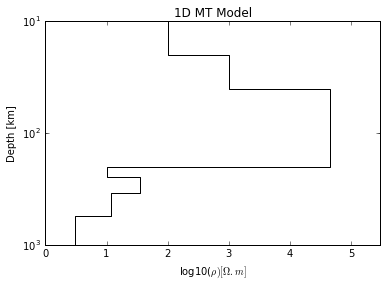

In [24]:
xModel = Model()
xMT = MT()
xModel, xMT, xPlot = getparameters()
printmodel(xModel, xPlot)

<h5 align='justify'>This model has parameters according to a layered Earth without lateral heterogeneity. This section is based in a gradual increase of resistivity in the Crust and Mantle until ~150 km of depth. In ~200 km of depht, we have a discontinuity that is related with the Lithosphere-Asthenosphere boundary
(LAB). And later, we have a Conducting mantle.</h5>

<h5 align='justify'>We made this model because we are testing if the MT method can recovery the structure bellow a high-resistance layer, like our model.</h5>

<h3>Impedances for 1D Model</h3>

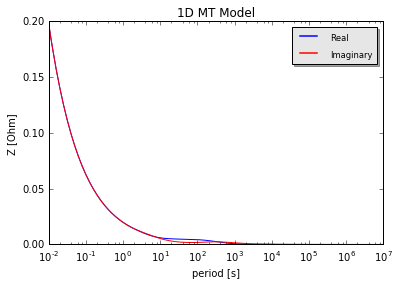

In [25]:
mtcurve( xModel, xMT )
plotz( xMT )

<h5 align='justify'>This graph shows the variation of the Impedance in fuction of the period. There is a important feature between the periods $10^{1}$ and $10^{2}$.</h5>

<h3>Apparent resisitivties and Phases for 1D Model</h3>

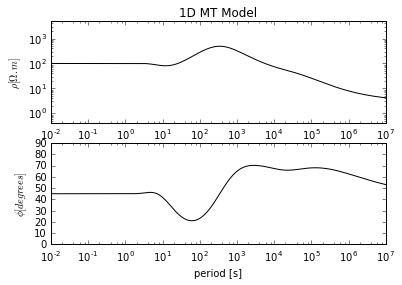

In [26]:
getrhopha( xMT )
plotrhopha( xMT )

<h5 align='justify'>This last graph shows the convertion of the impedances in apparent resisitivties and phases. We can observe between the periods $10^{1}$ e $10^{3}$ a bulge in the aparent resistivity and a large depression in the phase.  The segment is related with the high-resistance layer in our model. In the apparent resistivity we can see the gradual increase of the resitivity, later a high-resistivity value between the periods $10^{1}$ e $10^{3}$. After that we can observe a conductive behaviour in the high periods.<h/5>

<h5 align='justify'>The LAB is hidden below the high-resistance layer, and its signal is masked by the high-amplitude signal. Thus, it is hard to recover structures below high-resistance layers.<h/5>